In [1]:
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
import networkx as nx

from mrf_cut import create_pairwise_mrf, graph_cut_mrf, segment_image, get_unary_log_odds
from viztools import visualize_graph, viz_graph_3d

3. Basic Example of CRF Graph Cut

Give the reader an idea of the flow before diving into detail on the flow network 

3.1 Understanding the CRF

Start with a prescribed image (3x3)
Visualize it (fig 1a) and its conditional mrf by its side (with the true image superimposed)

The CRF explictly states what in a lot of literature is implictly stated; namely that the observed values are parameters of the unary potentials

Each factor is table, and each pixel is a random variable which can be either 0 or 1. Note that the 'pixel' in this case is the pixel of the 'true' image. Since the unary potentials are influenced by the observed values.

3.2 Constructing the Flow Network

Describe how the network can be constructed either as edges for both, or edges from either. They are equivalent in the binary case. Just because an edge connects the source to a pixel doesn't mean it really is that case. Show what it looks like for the image.

3.3 Finding the minimum cut of the Flow network

Using networkx, just do blank. We don't have to construct a mrf directly at all, but rather the flow network. Show that it indeed is the minimum energy.

4. Interpretation of the flow network representation

We can first start with the math, show that the cut capacity is equal to the minimum energy, except for a factor. But why does it work? 

The idea is not from considering the cut as minimum energy, but simply from the MAP concept. The parameters in the MAP representation are dependent on the values of each pixel, as well as the agreement of each pixel with its neighbors. You get a positive value from the unary potential, and one for blank. You can consider the flow network being realized from a set of statements about the configuration of the potential states, importantly the three statements, pixel 1 is white, pixel 2 is black, and pixels 1 and 2 agree, are independent statements, being represented by edges to the source, sink, and between eachother. These claims, of course, are contradictory. The idea is that we start with the set of claims that maximizes the total weight of the flow network, without considering contradictions. This means each node is connected to eachother, and each pixel is apart of both.

From here, we want to find the set of edges that when removed, corresponds to a configuration that is valid, and resulting graph has the highest likelihood. This is equivalent to the idea that the set of edges removed have the minimum sum weight. 

The s-t flow from the source to the sink nodes can now be considered a diagnostic. How do we know if there are contradictions in our current set of claims? If there is a non-zero flow from s to t, then this means there are assertions that pixels agree and are in opposite labels. When we remove enough edges such that there is no flow from s to t, we know we have a valid configuration. We can consider the maximum flow as the natural state the network takes in order to minimize energy, and from here, we want to remove the set of edges which still has the highest potential in the network. 

For example, take a two pixel flow network.

Describe the two pixel flow network, and the 3 possible states it can be in. Show how removing the minimum value leads us to the result.

Now visualize the maximum flow for the 3x3 image, and show how the edges that are limiting it stand out. 
 

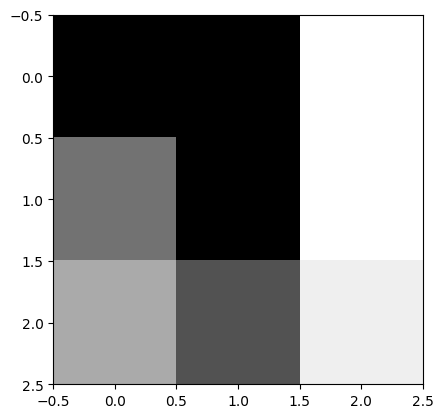

In [2]:
image = [
    [0.9, 0.9, 0.1],
    [0.6, 0.9, 0.1],
    [0.45, 0.7, 0.2]
]
plt.imshow(image, plt.get_cmap(name="Greys"))

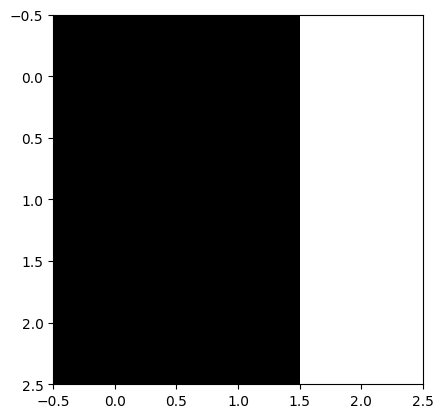

In [3]:
true_image = [
    [1, 1, 0.],
    [1, 1, 0.],
    [1, 1, 0]
]
plt.imshow(true_image, plt.get_cmap(name="Greys"))

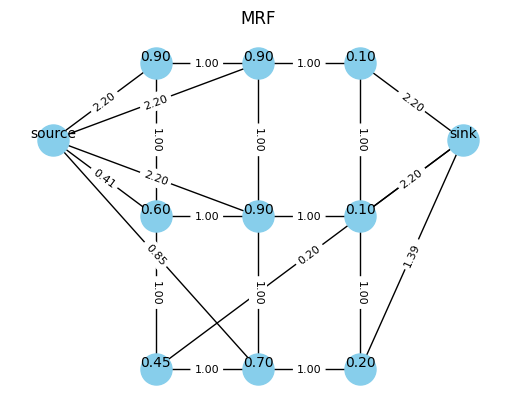

In [4]:
G = create_pairwise_mrf(image)
visualize_graph(G)

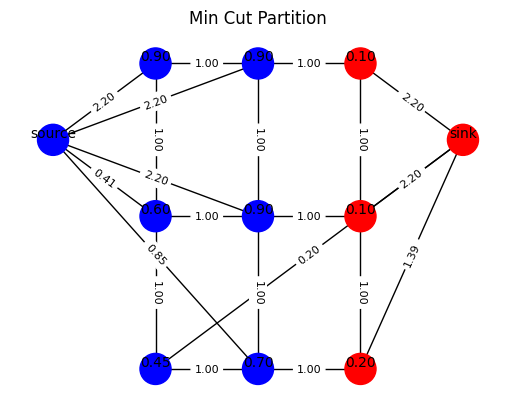

In [5]:
def visualize_partition(G: nx.Graph, partition):
    def get_node_colors(G):
        return ["blue" if node in partition[0] else "red" for node in G.nodes()]
    visualize_graph(G, node_color_fnc=get_node_colors, title="Min Cut Partition")
    
cut, partition = nx.minimum_cut(G, "source", "sink")
visualize_partition(G, partition)


In [6]:
max_flow, flow_dict = nx.maximum_flow(G, "source", "sink")

In [7]:
partition

({(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), 'source'},
 {(0, 2), (1, 2), (2, 2), 'sink'})

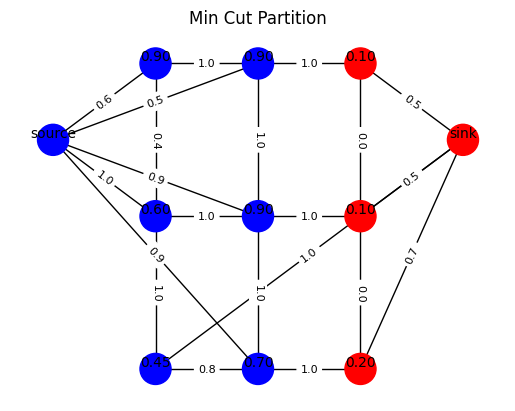

In [8]:
def visualize_flow(G: nx.Graph, flow_dict, partition):
    def get_node_colors(G):
        return ["blue" if node in partition[0] else "red" for node in G.nodes()]
    def get_edge_labels(G: nx.Graph):
        lbls = dict()
        for u, v, data in G.edges(data=True):
            flow = max(flow_dict[u].get(v, 0), flow_dict[v].get(u, 0))
            lbls[(u, v)] = f'{flow / data["capacity"]:.1f}'
        return lbls


    visualize_graph(G, node_color_fnc=get_node_colors, edge_label_fnc=get_edge_labels, title="Min Cut Partition")
    
cut, partition = nx.minimum_cut(G, "source", "sink")
visualize_flow(G, flow_dict, partition)


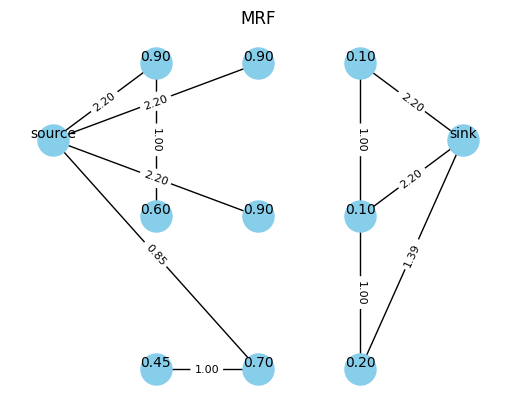

In [9]:
G_subset = G.copy()
full_edges = []
for u, v, data in G.edges(data=True):
    flow = max(flow_dict[u].get(v, 0), flow_dict[v].get(u, 0))
    if flow >= data["capacity"]:
        full_edges.append((u, v))
G_subset.remove_edges_from(full_edges)
visualize_graph(G_subset)

In [10]:
flow_dict

{'source': {(0, 0): 1.4054651081081644,
  (0, 1): 1.0,
  (1, 0): 0,
  (1, 1): 2.0,
  (2, 1): 0},
 'sink': {(0, 2): 0, (1, 2): 0, (2, 0): 0, (2, 2): 0},
 (0, 0): {'source': 0, (0, 1): 1, (1, 0): 0.4054651081081644},
 (0, 1): {'source': 0, (0, 0): 0, (0, 2): 1, (1, 1): 1},
 (0, 2): {'sink': 1, (0, 1): 0, (1, 2): 0},
 (1, 0): {'source': 0.4054651081081643, (0, 0): 0, (1, 1): 0, (2, 0): 1},
 (1, 1): {'source': 0, (0, 1): 0, (1, 0): 1.0, (1, 2): 1, (2, 1): 1},
 (1, 2): {'sink': 1, (0, 2): 0, (1, 1): 0, (2, 2): 0},
 (2, 0): {'sink': 0.20067069546215122, (1, 0): 0, (2, 1): 0.7993293045378489},
 (2, 1): {'source': 0.7993293045378489, (1, 1): 0, (2, 0): 0, (2, 2): 1.0},
 (2, 2): {'sink': 1.0, (1, 2): 0, (2, 1): 0}}

In [11]:
import networkx as nx
import plotly.graph_objs as go
from plotly.offline import iplot


viz_graph_3d(G)